In [1]:

%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()



RuntimeError: imageio.ffmpeg.download() has been deprecated. Use 'pip install imageio-ffmpeg' instead.'

# Quik look at the data


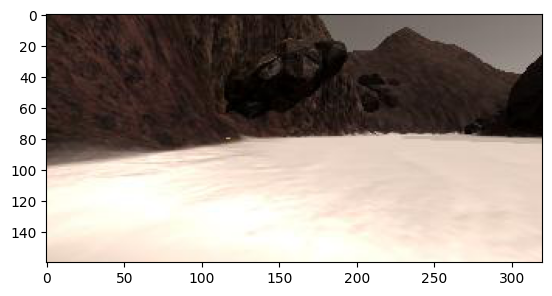

In [2]:
path = '../test_dataset/IMG/*'#back to steps to parent
img_list =glob.glob(path)
#mg_list
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)


# Calibration Data

Read in and display example grid and rock sample calibration images. You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest.


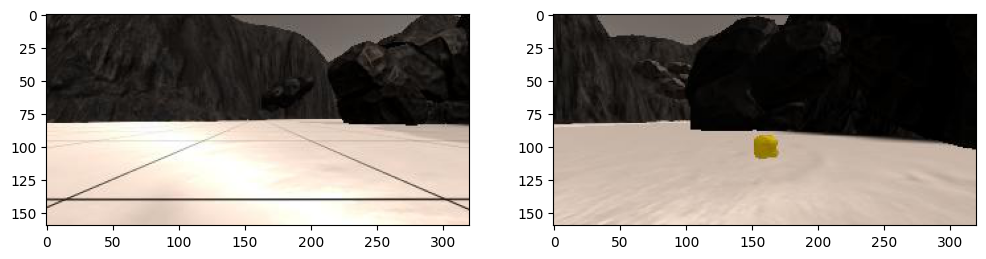

In [3]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)



# Perspective Transform

Define the perspective transform function from the lesson and test it on an image.


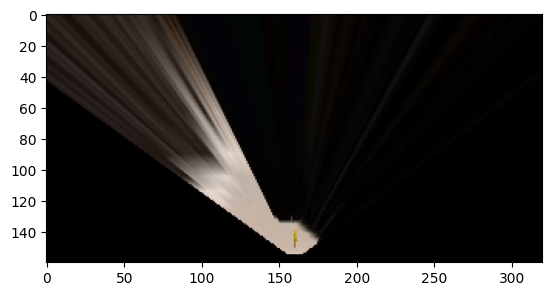

In [4]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)


# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)# filter definetion
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped#  end of definetion


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 # output image 5x5
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset=6 
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])# rough estimation
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
#fig = plt.figure(figsize=(12,3))
#plt.subplot(121)
#warped = perspect_transform(grid_img, source, destination)
#plt.imshow(warped)
warped = perspect_transform(rock_img, source, destination)
#plt.subplot(122)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)


# Color Thresholding

Define the color thresholding function from the lesson and apply it to the warped image

TODO: Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for. Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.
Hints and Suggestion:

    For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!

    For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors. You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!). Feel free to get creative and even bring in functions from other libraries. Here's an example of color selection using OpenCV.

    Beware However: if you start manipulating images with OpenCV, keep in mind that it defaults to BGR instead of RGB color space when reading/writing images, so things can get confusing.



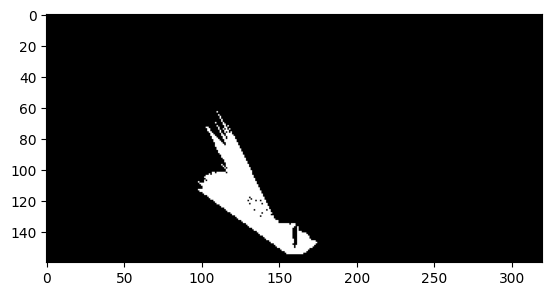

In [5]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)


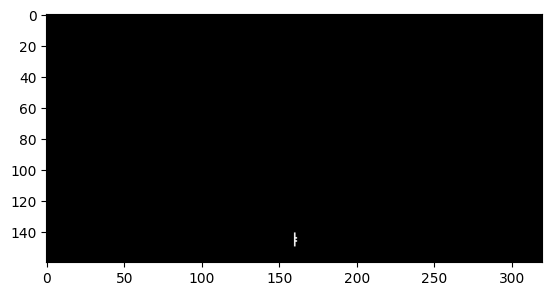

In [28]:

def obstacles_tresh(img, obs_thresh=(210, 160, 121)):
    color_select = np.zeros_like(img[:,:,0])
    obs = (img[:,:,0] <= obs_thresh[0]) & (img[:,:,1] <= obs_thresh[1]) & (img[:,:,2] <= obs_thresh[2])
    color_select[obs] = 1
    return color_select

def rock_tresh(img, yellow_thresh=(90, 90, 30)):
    color_select = np.zeros_like(img[:,:,0])
    rock = (img[:,:,0] > yellow_thresh[0]) & (img[:,:,1] > yellow_thresh[1]) & (img[:,:,2] < yellow_thresh[2])
    color_select[rock] = 1
    return color_select
rocks = perspect_transform(rock_tresh(rock_img), source, destination)
obstacles = perspect_transform(obstacles_tresh(rock_img), source, destination)   

plt.imshow(obstacles, cmap='gray')
plt.imshow(rocks, cmap='gray')

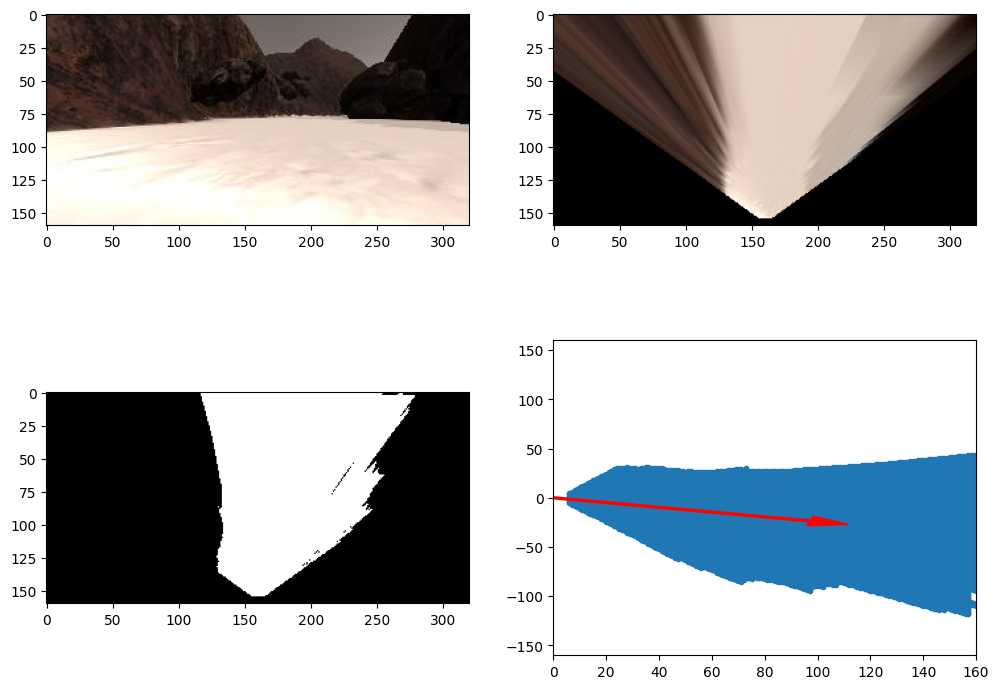

In [54]:

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float64)
    y_pixel = -(xpos - binary_img.shape[0] ).astype(np.float64)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
